In [29]:
import sys
import os
import numpy as np
import warnings
from tqdm.auto import tqdm
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter


# Suppress all warnings
warnings.filterwarnings("ignore")

## replace with root project dir
PROJECT_DIR = "/mnt/workspace/__ing/llming/DTC/audio_podcast_qa_assistant"
sys.path.append(PROJECT_DIR)

from utils.utils import (
    initialize_env_variables,
    flatten_list_of_lists,
    sample_from_list,
    read_json_file,
    save_json_file,
    extract_item_by_keys,
    save_to_pickle,
    load_pickle,
    get_json_files_in_dir,
    read_json_file
)

initialize_env_variables()

from utils.questions import (extract_questions,
                             group_questions_by_episode, 
                             openai_process_questions,
                            filter_corrupted_qs,
                            count_question_marks)
from utils.multithread import map_progress
from datasets import load_dataset, Dataset
from utils.ollama import embed_document
from utils.variables import OLLAMA_CLIENT, INDEX_NAME, ES_CLIENT

from transformers import LEDForConditionalGeneration, LEDTokenizer
import torch

from utils.query import (
    elastic_search_text, elastic_search_knn, elastic_search_hybrid_rrf
)
from utils.variables import ES_CLIENT
from utils.query import (
    elastic_search_text,
    elastic_search_knn,
    elastic_search_hybrid_rrf,
    get_answer
)
from utils.variables import ES_CLIENT
from utils.evaluate import (hit_rate, mrr, retrieve_relevance,
                            retrieve_adjusted_relevance, adjusted_hit_rate,
                            adjusted_mrr)

Initialized environment variables listed in: /mnt/workspace/__ing/llming/DTC/audio_podcast_qa_assistant/.env


In [2]:
pickle_file_path = os.path.join(
    PROJECT_DIR, 
    "data/generated_embeddings/vectorized_questions.pkl"
)
vectorized_questions = load_pickle(pickle_file_path)

# Evaluating Retrieval

## MRR & HIT_RATE

In [3]:
search_func_list = [
    elastic_search_text,
    elastic_search_knn,
    elastic_search_hybrid_rrf
]
search_func_keys_list = [
    {"query":"question"},
    {"query_vector":"question_vector"},
    {"query":"question", "query_vector":"question_vector"}    
]
performance = []

for i in range(len(search_func_list)):
    relevance = map_progress(
        f=lambda question_dict: retrieve_relevance(
            question_dict=question_dict,
            search_func=search_func_list[i],
            **search_func_keys_list[i]
        ),
        seq=vectorized_questions,
        max_workers=6,
        verbose=False
    )
    
    performance.append(
        {
            "Search": search_func_list[i].__name__,
            "HR": hit_rate(relevance),
            "MRR": mrr(relevance)
        }
    )
    
pd.DataFrame(performance)

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

,Search,HR,MRR
0,elastic_search_text,0.641026,0.503775
1,elastic_search_knn,0.705128,0.586111
2,elastic_search_hybrid_rrf,0.786325,0.671795


## Adjusted MRR & HIT_RATE

In [4]:
search_func_list = [
    elastic_search_text,
    elastic_search_knn,
    elastic_search_hybrid_rrf
]
search_func_keys_list = [
    {"query":"question"},
    {"query_vector":"question_vector"},
    {"query":"question", "query_vector":"question_vector"}    
]
performance = []

for i in range(len(search_func_list)):
    relevance = map_progress(
        f=lambda question_dict: retrieve_adjusted_relevance(
            question_dict=question_dict,
            search_func=search_func_list[i],
            **search_func_keys_list[i]
        ),
        seq=vectorized_questions,
        max_workers=6,
        verbose=False
    )
    
    performance.append(
        {
            "Search": search_func_list[i].__name__,
            "Adjusted HR": adjusted_hit_rate(relevance),
            "Adjusted MRR": adjusted_mrr(relevance)
        }
    )
    
pd.DataFrame(performance)

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

,Search,Adjusted HR,Adjusted MRR
0,elastic_search_text,0.643162,0.505912
1,elastic_search_knn,0.722222,0.594017
2,elastic_search_hybrid_rrf,0.799145,0.680520


# Evaluating RAG

Note: Response Time & OpenAI Cost/Tokens includes evaluation (llm as a judge) which is fixed across all models to be $EVAL_MODEL, specified in .env file

## ollama/phi3

In [5]:
query = vectorized_questions[0]["question"]
model_choice = "ollama/phi3"
search_type = "Hybrid" # we will fix it since it's the best performing

In [8]:
ans = get_answer(
    query=query,
    title_query=None,
    model_choice=model_choice,
    search_type=search_type
)

In [9]:
ans

{'answer': '\nNicole Perlroth here discussing cybersecurity in the podcast with Lex Fridman #266:  \n   \n"Hello, my name is Nicole Perlroth and this is \'The Cyber Secured Future\' from WNYC Studios. I am a senior reporter at ProPublica where we try to make technology work for everyone in society, often times that gets complicated because you have the tech companies building these amazing systems while they can also exploit them through their data collection tools and privacy loopholes built into our products as consumers.  \n   \nBut today on my \'The Cyber Secured Future\' I am joined by Lex Fridman to discuss cybersecurity in depth, its implications for humanity going forward not only with the technical aspect of it but also from a policy standpoint and philosophical perspective where we try as well how can mankind keep ahead or at least stay relevant and even compete against AI development.  \n   \nWelcome to The Cyber Secured Future, Nicole Perlroth reporting for WNYC Studios on 

Answer is too long, took too much time, and was completely a non-sense.
We are not going to evaluate phi3 any further.

## ollama/gemma:2b

In [ ]:
query = vectorized_questions[0]["question"]
model_choice = "ollama/gemma:2b"
search_type = "Hybrid" # we will fix it since it's the best performing

In [ ]:
ans = get_answer(
    query=query,
    title_query=None,
    model_choice=model_choice,
    search_type=search_type
)

In [20]:
ans

{'answer': "Sure, here's a summary of the conversation:\n\nThe conversation is about the lack of information on social engineering and the implications for businesses and organizations that allow employees to work remotely.\n\nThe podcast host discusses the concept of social engineering and how it can be used to gain unauthorized access to sensitive data. He also addresses the issue of China and Russia planting spies inside US companies and how this can create a hostile work environment.\n\nThe conversation also suggests that organizations need to be vigilant about social engineering attacks and should conduct thorough background checks on new employees to mitigate the risk of social engineering.\n\nThe conversation suggests that organizations need to be wary of social engineering attacks and should conduct thorough background checks on new employees to mitigate the risk of social engineering.\n\nThe conversation also raises the issue of how social engineering can create xenophobia in 

Shorter than phi3, also faster, but still, a complete non-sense.

## ollama/llama3.1

In [47]:
query = vectorized_questions[0]["question"]
model_choice = "ollama/llama3.1"
search_type = "Hybrid" # we will fix it since it's the best performing

In [48]:
ans = get_answer(
    query=query,
    title_query=None,
    model_choice=model_choice,
    search_type=search_type
)

In [49]:
ans

{'answer': 'Eric Weinstein, a mathematician and podcaster, is discussing topics such as artificial intelligence (AGI), AI, the Lex Fridman podcast, AGI, JRE (Joe Rogan Experience), MIT AI, and his thoughts on various subjects. \n\nHe talks about: \n- The silence around Jeffrey Epstein, a wealthy and influential financier who was convicted of sex trafficking minors\n- Heroic actions to take during times of societal crisis or corruption\n- Cybersecurity issues including the impact of remote work due to social engineering threats that have companies overly cautious about hiring people from high-risk countries like China and Russia \n- The risks of insider attacks and xenophobia within organizations',
 'tags': '#lex fridman; #lex mit; #mit ai; #snowden; #nicole perlroth; #eric weinstein; #china; #agi; #lex jre; #ai; #new york times; #hacking; #artificial intelligence; #artificial intelligence podcast; #cybersecurity; #lex ai; #russia; #ai podcast; #lex podcast; #cyberattack',
 'titles': {'

Shorter than phi3, also faster, but still, a complete non-sense.
Worse than gemma:2b.

## ollama/gemma2:2b

In [50]:
query = vectorized_questions[0]["question"]
model_choice = "ollama/gemma2:2b"
search_type = "Hybrid" # we will fix it since it's the best performing

In [51]:
ans = get_answer(
    query=query,
    title_query=None,
    model_choice=model_choice,
    search_type=search_type
)

In [52]:
ans

{'answer': 'It seems you\'re asking for a response on how an AI might analyze information about social engineering and hacking that relates to political contexts and specific historical events.\n\nHere is a combined answer integrating different perspectives and using the provided context:\n\n## Analyzing Social Engineering with Lex Fridman\'s Podcast: A Case Study Approach\n\nYou brought up a fascinating analysis of social engineering in a cybersecurity context, specifically concerning remote work environments fueled by increasing tech adoption. \n\n**Think about it this way:**  There seems to be a lot more happening than just the technology itself. We\'re seeing potential for manipulation and control beyond what we are used to from traditional hacking efforts: \n\n\n1. **Social Engineering as a Weapon (Case study example)**: The podcast showcases how social engineering can turn routine interactions into tools of espionage.  Imagine a scenario at a company:\n\n    * A seemingly regular

Longer than gemma:2b (hence costlier evaluation); complete non-sense

## openai/gpt-3.5-turbo

In [10]:
model_choice = "openai/gpt-3.5-turbo"
search_type = "Hybrid" # we will fix it since it's the best performing

In [14]:
# Get answers

answers_gpt35_1 = map_progress(
    f=lambda question: get_answer(
        query=question["question"],
        title_query=None,
        model_choice=model_choice,
        search_type=search_type
    ),`
    seq=vectorized_questions,
    max_workers=6,
    verbose=False
)

  0%|          | 0/234 [00:00<?, ?it/s]

In [18]:
# storing to avoid losing it as _1, we might regenerate to check consistency

save_to_pickle(
    answers_gpt35_1, 
    os.path.join(
        PROJECT_DIR,
        "data/generated_answers/answers_gpt35_1.pkl"
    )
)

In [28]:
# Extract relevance, response time, and openai cost (cost includes eval cost)

relevance_gpt35_1 = [ans['relevance'] for ans in answers_gpt35_1]
response_time_gpt35_1 = [ans['response_time'] for ans in answers_gpt35_1]
openai_cost_gpt35_1 = [ans['openai_cost'] for ans in answers_gpt35_1]

In [30]:
Counter(relevance_gpt35_1)

Counter({'RELEVANT': 219, 'PARTLY_RELEVANT': 10, 'NON_RELEVANT': 5})

Expected Response time is 1.54 (+/- 0.94) seconds.


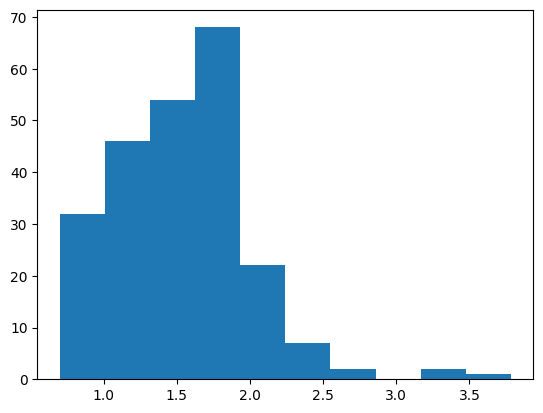

In [34]:
# response time:

mean_ = round(np.mean(response_time_gpt35_1), 2)
std_ = round(np.std(response_time_gpt35_1) * 2, 2)

print(f"Expected Response time is {mean_} (+/- {std_}) seconds.")
plt.hist(response_time_gpt35_1); plt.show()

Expected OpenAI Cost is 0.01506 (+/- 0.00338) $.


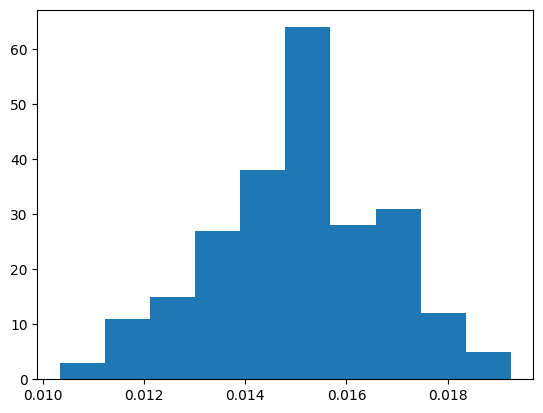

In [36]:
# openai cost:

mean_ = round(np.mean(openai_cost_gpt35_1), 5)
std_ = round(np.std(openai_cost_gpt35_1) * 2, 5)

print(f"Expected OpenAI Cost is {mean_} (+/- {std_}) $.")
plt.hist(openai_cost_gpt35_1); plt.show()

## openai/gpt-4o-mini

In [38]:
model_choice = "openai/gpt-4o-mini"
search_type = "Hybrid" # we will fix it since it's the best performing

In [40]:
# Get answers

answers_gpt4o_mini_1 = map_progress(
    f=lambda question: get_answer(
        query=question["question"],
        title_query=None,
        model_choice=model_choice,
        search_type=search_type
    ),
    seq=vectorized_questions,
    max_workers=6,
    verbose=False
)

  0%|          | 0/234 [00:00<?, ?it/s]

In [41]:
# storing to avoid losing it as _1, we might regenerate to check consistency

save_to_pickle(
    answers_gpt4o_mini_1, 
    os.path.join(
        PROJECT_DIR,
        "data/generated_answers/answers_gpt4o_mini_1.pkl"
    )
)

In [42]:
# Extract relevance, response time, and openai cost (cost includes eval cost)

relevance_gpt4o_mini_1 = [ans['relevance'] for ans in answers_gpt4o_mini_1]
response_time_gpt4o_mini_1 = [ans['response_time'] for ans in answers_gpt4o_mini_1]
openai_cost_gpt4o_mini_1 = [ans['openai_cost'] for ans in answers_gpt4o_mini_1]

In [43]:
Counter(relevance_gpt4o_mini_1)

Counter({'RELEVANT': 229, 'PARTLY_RELEVANT': 5})

Expected Response time is 1.64 (+/- 1.27) seconds.


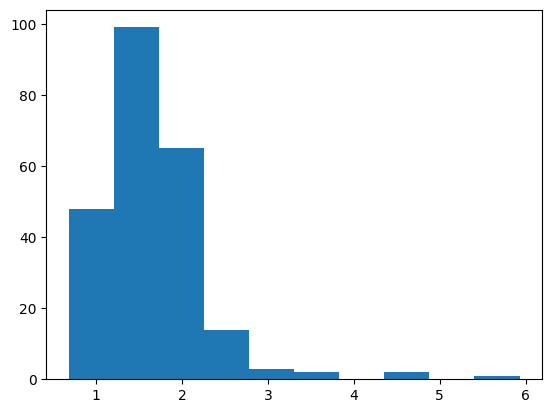

In [44]:
# response time:

mean_ = round(np.mean(response_time_gpt4o_mini_1), 2)
std_ = round(np.std(response_time_gpt4o_mini_1) * 2, 2)

print(f"Expected Response time is {mean_} (+/- {std_}) seconds.")
plt.hist(response_time_gpt4o_mini_1); plt.show()

Expected OpenAI Cost is 0.08479 (+/- 0.02121) $.


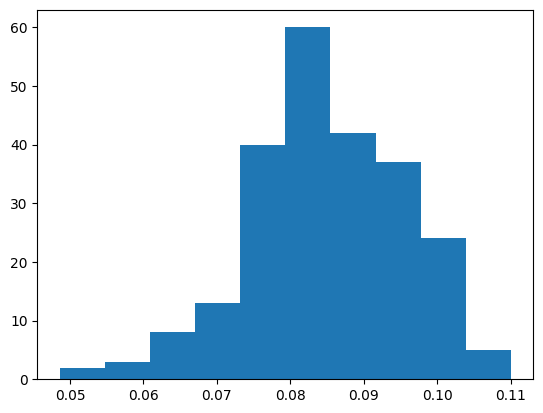

In [46]:
# openai cost:

mean_ = round(np.mean(openai_cost_gpt4o_mini_1), 5)
std_ = round(np.std(openai_cost_gpt4o_mini_1) * 2, 5)

print(f"Expected OpenAI Cost is {mean_} (+/- {std_}) $.")
plt.hist(openai_cost_gpt4o_mini_1); plt.show()

## openai/gpt-4o

SKIPPED: It would be very costly to try